In [22]:
import numpy as np 
import cv2
import time
# import read_position_data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from flax import linen as nn
import skimage

7


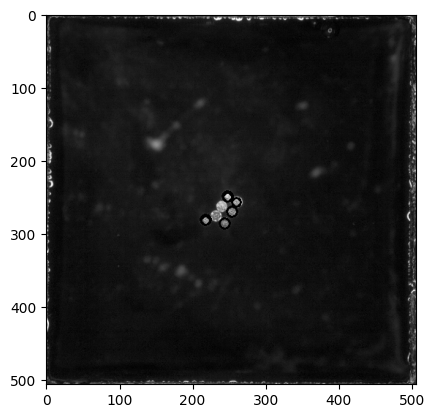

In [ ]:
input_data = plt.imread("../images/latest_camera_image.png")
input_data = input_data[:,:,0]
input_data = np.array(input_data*255, dtype=np.uint8)
threshold = cv2.adaptiveThreshold(input_data,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,-9)
hough_results = skimage.transform.hough_circle(threshold, np.arange(5,50))
accums, cx, cy, radii = skimage.transform.hough_circle_peaks(hough_results, np.arange(5,50), total_num_peaks=7)
print(len(radii))
circle_thickness = int(2)
circle_color = (0, 0, 255)  # openCV: BGR

output_img = input_data
for raft_id in np.arange(len(radii)):
    output_img = cv2.circle(output_img, (cx[raft_id], cy[raft_id]), radii[raft_id],
                            circle_color, circle_thickness)
plt.imshow(output_img,cmap='gray')

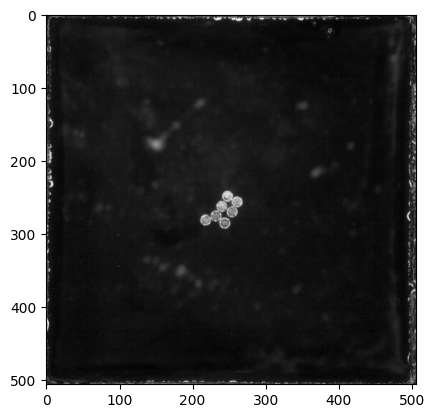

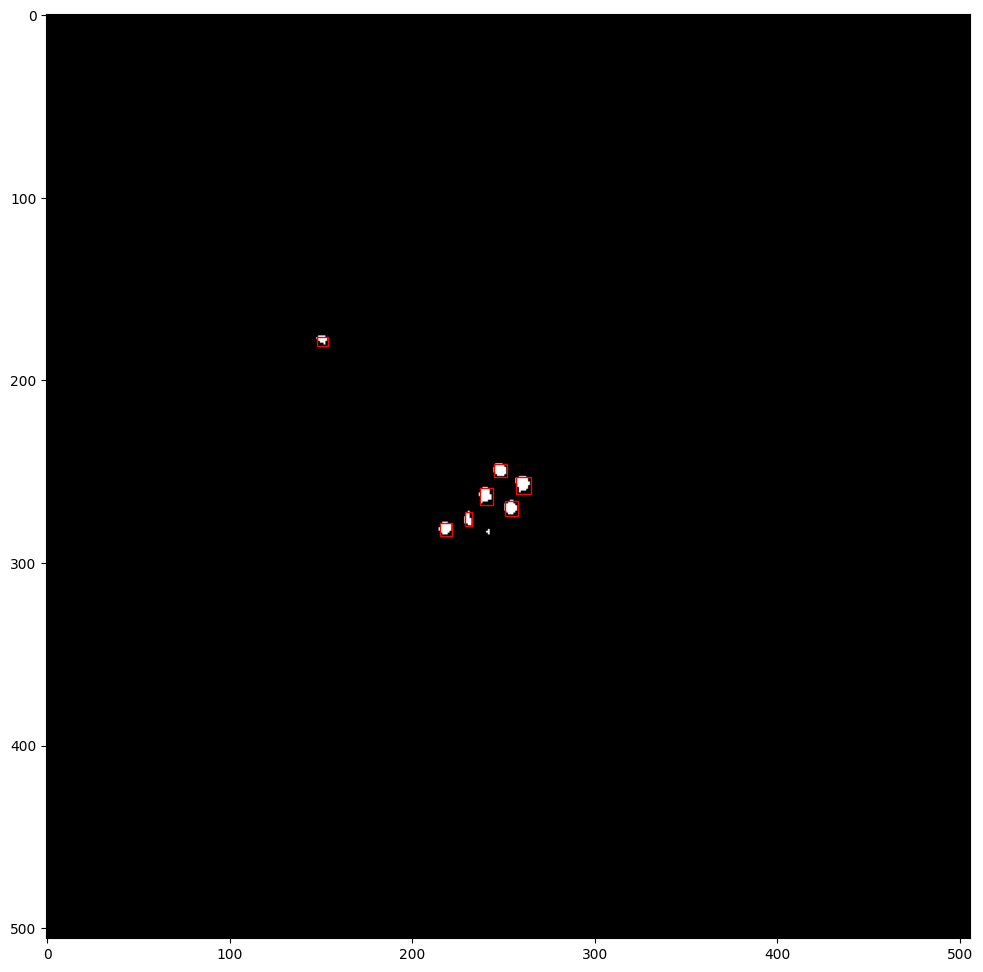

In [31]:
mean = np.mean(input_data)
std = np.std(input_data)
input_data = (input_data - mean) / std
plt.imshow(input_data, cmap='gray')
image = input_data>3.5
image = image.astype(np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
image = cv2.erode(image, kernel, iterations=2)
label_image = skimage.measure.label(image)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(image, cmap='gray')
for region in skimage.measure.regionprops(label_image, intensity_image=image):
    # Everywhere, skip small and large areas
    if region.area < 10 or region.area > 80000:
        continue

    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

In [88]:


# (
#     ground_truth_positions,
#     input_data,
#     validation_ground_truth_positions,
#     validation_input_data,
# ) = read_position_data.get_data()
input_data = plt.imread("../images/latest_camera_image.png")
input_data = input_data[:,:,0]
print(input_data.shape)
input_data = cv2.resize(input_data, (506,506))

mean = np.mean(input_data)
std = np.std(input_data)
input_data = (input_data - mean) / std
image = input_data>3.5

(506, 506)


7


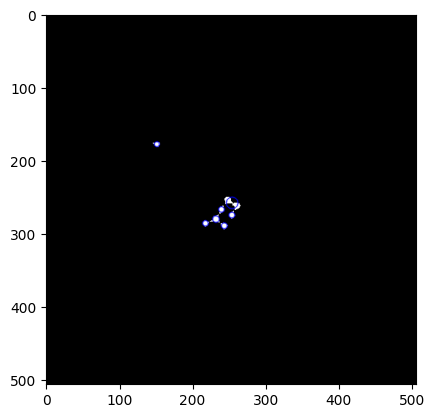

In [89]:


image = np.array(image * 255, dtype=np.uint8) 
params = cv2.SimpleBlobDetector_Params()
params.filterByColor = True
params.blobColor = 255
# params.filterByCircularity = False
# params.minCircularity = 0.1
# params.maxCircularity = 1
# params.filterByConvexity = False
# params.minConvexity = 0.01
# params.maxConvexity = 1
params.filterByArea = True
params.maxArea = 130
params.minArea = 10
# params.filterByCircularity = True
# params.minCircularity = 0.9
# params.maxCircularity = 1
params.filterByConvexity = False  # Allow irregular shapes
params.filterByInertia = False  # Allow elongated shapes
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
image = cv2.erode(image, kernel, iterations=2)
# image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(image.astype(np.uint8))
print(len(keypoints))
image_with_keypoints = cv2.drawKeypoints(image, keypoints, np.array([]), (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(image_with_keypoints, cmap="gray")
plt.savefig("blob_detection.png")
# plt.show()


In [ ]:
number_keypoints = 0
number_samples = len(input_data)
iteration_start = time.time()
movie_writer = cv2.VideoWriter("blob_detection.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 1, (image.shape[1], image.shape[0]))
for i in range(number_samples):
    params = cv2.SimpleBlobDetector_Params()
    params.filterByColor = True
    params.blobColor = 255
    # params.filterByCircularity = False
    # params.minCircularity = 0.1
    # params.maxCircularity = 1
    # params.filterByConvexity = False
    # params.minConvexity = 0.01
    # params.maxConvexity = 1
    params.filterByArea = True
    params.maxArea = 130
    params.minArea = 50
    # params.filterByCircularity = True
    # params.minCircularity = 0.9
    # params.maxCircularity = 1
    params.filterByConvexity = False  # Allow irregular shapes
    params.filterByInertia = False  # Allow elongated shapes
    

    detector = cv2.SimpleBlobDetector_create(params)
    image = input_data[i] > 1
    image = np.array(image * 255, dtype=np.uint8) 
    image = nn.avg_pool(image, (2, 2), strides=(1, 1), padding="Same") ==63
    image = np.array(image*255, dtype=np.uint8)
    
    # plt.imshow(image, cmap="gray")
    start = time.time()
    keypoints = detector.detect(image)
    number_keypoints += len(keypoints)
    # print(f"detected {len(keypoints)} keypoints and it took {time.time() - start} seconds, for {i=}") if len(keypoints) > 0 else None
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, np.array([]), (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        radius = int(kp.size / 2 * 1.6)
        cv2.circle(image, (x, y), radius, (0, 0, 0), -1)
    # plt.figure()
    # plt.imshow(image_with_keypoints, cmap="gray")
    # plt.figure()

    # plt.imshow(image, cmap="gray")
    params.filterByArea = True
    params.minArea = 50
    params.maxArea = 2000
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(image)
    # print(f"detected {len(keypoints)} additional keypoints after removing keypoints and it took {time.time() - start} seconds, for {i=}") if len(keypoints) > 0 else None
    image_with_keypoints = cv2.drawKeypoints(image_with_keypoints, keypoints, np.array([]), (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # plt.figure()
    # plt.imshow(image_with_keypoints, cmap="gray")
    movie_writer.write(image_with_keypoints)
    number_keypoints += len(keypoints)*2
iteration_end = time.time()
cv2.destroyAllWindows()
movie_writer.release()

In [ ]:
print(number_keypoints/number_samples, (iteration_end - iteration_start)/number_samples)

212.11116666666666 0.051850780328114826


: 